In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import toad
from sklearn.base import TransformerMixin
from sklearn.metrics import roc_auc_score, roc_curve
import scikitplot as skplt

%matplotlib inline

## 载入数据

In [2]:
data = pd.read_csv('/data/credit_model/lec6/credit_score.csv')

In [3]:
data.head()

,user_id,credit_score,label,register,month
0,ad307dd2-f8e6-471a-a7d1-fbcb871cdfca,99.465803,0.0,201712,201801
1,ea8233e7-64a4-4e0d-af68-2a99c6791b1c,98.818422,0.0,201712,201801
2,361c1d32-c75a-4e20-85cb-f5cb45e72e7f,99.584214,0.0,201712,201801
3,b1bbc49b-c254-4cee-a797-23fefac8ed3c,99.237402,0.0,201712,201801
4,03372f15-6654-4f77-b1f8-9bd3448f427f,99.698525,0.0,201802,201802


## 计算模型指标

In [4]:
def get_auc(ytrue, yprob):
    auc = roc_auc_score(ytrue, yprob)
    if auc < 0.5:
        auc = 1 - auc
    return auc

def get_ks(ytrue, yprob):
    fpr, tpr, thr = roc_curve(ytrue, yprob)
    ks = max(abs(tpr - fpr))
    return ks

def get_gini(ytrue, yprob):
    auc = roc_auc_score(ytrue, yprob)
    if auc < 0.5:
        auc = 1 - auc
    gini = 2 * auc - 1
    return gini

In [5]:
def get_metrics_all(df, label, score):
    auc = get_auc(df[label], df[score])
    ks = get_ks(df[label], df[score])
    gini = get_gini(df[label], df[score])
    
    return pd.Series({'auc': auc, 'ks': ks, 'gini': gini})

def get_metrics_group(df, group, label, score):
    auc = df.groupby(group).apply(lambda x: get_auc(x[label], x[score]))
    ks = df.groupby(group).apply(lambda x: get_ks(x[label], x[score]))
    gini = df.groupby(group).apply(lambda x: get_gini(x[label], x[score]))
    
    return pd.DataFrame({'auc': auc, 'ks': ks, 'gini': gini}).reset_index()

In [6]:
get_metrics_group(data, 'month', 'label', 'credit_score')

,month,auc,ks,gini
0,201801,0.832063,0.510802,0.664127
1,201802,0.849211,0.541009,0.698422
2,201803,0.835025,0.514085,0.670050
3,201804,0.824220,0.492175,0.648441
4,201805,0.807261,0.459830,0.614522
5,201806,0.783744,0.420691,0.567488
6,201807,0.745443,0.361738,0.490886
7,201808,0.757778,0.397368,0.515557


In [16]:
class ScoreBin(TransformerMixin):
    model = None

    @classmethod
    def round_num(cls, x, num):
        if num >= 0:
            return round(x, num)
        else:
            return round(x / 10 ** -num, 0) * (10 ** -num)

    def fit(self, score, label, **kwargs):
        df = pd.DataFrame({'score': score, 'label': label})
        num = 5
        while len(df['score'].unique()) > 5000:
            df['score'] = df['score'].apply(lambda x: self.round_num(x, num))
            num -= 1

        self.model = toad.transform.Combiner()

        method = kwargs.get('method', 'quantile')
        if method in ['quantile', 'step', 'kmeans']:
            self.model.fit(df[['score', 'label']], y='label',
                           method=method, n_bins=kwargs.get('n_bins', 10),
                           exclude=list(), empty_separate=True)
        elif method in ['chi', 'dt']:
            self.model.fit(df[['score', 'label']], y='label',
                           method=method, min_samples=kwargs.get('min_samples', 0.05),
                           exclude=list(), empty_separate=True)
        else:
            raise ValueError('bin method should be quantile, step, kmeans, chi, dt')

        return self

    def transform(self, score):
        df = pd.DataFrame({'score': score})
        return self.model.transform(df[['score']], labels=True)['score']

In [17]:
model = ScoreBin()
model.fit(data['credit_score'], data['label'])
data['score_bin'] = model.transform(data['credit_score'])

In [98]:
def get_score_bin_stat_all(df, label, score_bin):
    df_stat = df.groupby(score_bin).agg(total=(label, 'count'),
                                  bad=(label, 'sum'),
                                  bad_rate=(label, 'mean')).reset_index()

    total = df_stat['total'].sum()
    df_stat['total_ratio'] = df_stat['total'] / total

    return df_stat.reset_index()[[score_bin, 'total', 'total_ratio', 'bad', 'bad_rate']]

In [100]:
df_stat = get_score_bin_stat_all(data[data['register']==201711],'label', 'score_bin', )
df_stat

,score_bin,total,total_ratio,bad,bad_rate
0,00.[-inf ~ 87.5),268,0.104118,35.0,0.130597
1,01.[87.5 ~ 93.1),297,0.115385,18.0,0.060606
2,02.[93.1 ~ 95.6),269,0.104507,7.0,0.026022
3,03.[95.6 ~ 97.1),274,0.106449,10.0,0.036496
4,04.[97.1 ~ 98.0),214,0.083139,6.0,0.028037
5,05.[98.0 ~ 98.7),269,0.104507,2.0,0.007435
6,06.[98.7 ~ 99.2),240,0.093240,0.0,0.000000
7,07.[99.2 ~ 99.6),271,0.105284,0.0,0.000000
8,08.[99.6 ~ 99.8),208,0.080808,0.0,0.000000
9,09.[99.8 ~ inf),264,0.102564,1.0,0.003788


In [72]:
def get_stat(df, group, score_bin, label):
    key = group + [score_bin] if isinstance(group, list) else [group, score_bin]
    print(key)
    df_stat = data.groupby(key).agg(total=(label, 'count'),
                                    bad=(label, 'sum'),
                                    bad_rate=(label, 'mean'))
    
    df_stat = df_stat.reset_index()

    df_total = df_stat.groupby(group).agg(total_sum=('total', 'sum')).reset_index()
    df_stat = df_stat.merge(df_total, on=group, how='left')
    
    df_stat['total_ratio'] = df_stat['total'] / df_stat['total_sum']
    
    return df_stat.reset_index()[key+['total', 'total_ratio', 'bad', 'bad_rate']]

In [101]:
df_stat = get_stat(data, 'register', 'score_bin', 'label')
df_stat

['register', 'score_bin']


,register,score_bin,total,total_ratio,bad,bad_rate
0,201711,00.[-inf ~ 87.5),268,0.104118,35.0,0.130597
1,201711,01.[87.5 ~ 93.1),297,0.115385,18.0,0.060606
2,201711,02.[93.1 ~ 95.6),269,0.104507,7.0,0.026022
3,201711,03.[95.6 ~ 97.1),274,0.106449,10.0,0.036496
4,201711,04.[97.1 ~ 98.0),214,0.083139,6.0,0.028037
...,...,...,...,...,...,...
95,201808,05.[98.0 ~ 98.7),9473,0.116933,111.0,0.011718
96,201808,06.[98.7 ~ 99.2),9886,0.122031,68.0,0.006878
97,201808,07.[99.2 ~ 99.6),11021,0.136042,57.0,0.005172
98,201808,08.[99.6 ~ 99.8),7624,0.094110,18.0,0.002361


In [102]:
df_stat[df_stat['register']==201711]

,register,score_bin,total,total_ratio,bad,bad_rate
0,201711,00.[-inf ~ 87.5),268,0.104118,35.0,0.130597
1,201711,01.[87.5 ~ 93.1),297,0.115385,18.0,0.060606
2,201711,02.[93.1 ~ 95.6),269,0.104507,7.0,0.026022
3,201711,03.[95.6 ~ 97.1),274,0.106449,10.0,0.036496
4,201711,04.[97.1 ~ 98.0),214,0.083139,6.0,0.028037
5,201711,05.[98.0 ~ 98.7),269,0.104507,2.0,0.007435
6,201711,06.[98.7 ~ 99.2),240,0.093240,0.0,0.000000
7,201711,07.[99.2 ~ 99.6),271,0.105284,0.0,0.000000
8,201711,08.[99.6 ~ 99.8),208,0.080808,0.0,0.000000
9,201711,09.[99.8 ~ inf),264,0.102564,1.0,0.003788


In [108]:
def get_bad_rate_group(df_stat, group, bad_rate, score_bin):
    if isinstance(group, list) and len(group) > 1:
        df_bad_rate = pd.pivot_table(df_stat, values=bad_rate, index=[score_bin],
                            columns=group, aggfunc=np.sum)
        df_bad_rate.columns = ['_'.join([str(x) for x in col]) for col in df_bad_rate.columns]
    else:
        df_bad_rate = pd.pivot_table(df_stat, values=bad_rate, index=[score_bin],
                            columns=group, aggfunc=np.sum)
        df_bad_rate.columns = [str(x) for x in df_bad_rate.columns]
    
    return df_bad_rate.reset_index()

def get_total_ratio_group(df_stat, group, total_ratio, score_bin):
    if isinstance(group, list) and len(group) > 1:
        df_bad_rate = pd.pivot_table(df_stat, values=total_ratio, index=[score_bin],
                            columns=group, aggfunc=np.sum)
        df_bad_rate.columns = ['_'.join([str(x) for x in col]) for col in df_bad_rate.columns]
    else:
        df_bad_rate = pd.pivot_table(df_stat, values=total_ratio, index=[score_bin],
                            columns=group, aggfunc=np.mean)
        df_bad_rate.columns.name = None
    
    return df_bad_rate.reset_index()

In [111]:
df_bad_rate = get_bad_rate_group(df_stat, 'register', 'bad_rate', 'score_bin')
df_bad_rate

,score_bin,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,00.[-inf ~ 87.5),0.130597,0.218995,0.217289,0.237505,0.235980,0.142163,0.127736,0.108372,0.087516,0.063907
1,01.[87.5 ~ 93.1),0.060606,0.094300,0.091696,0.111265,0.105478,0.057023,0.060103,0.052911,0.043499,0.041653
2,02.[93.1 ~ 95.6),0.026022,0.054105,0.053518,0.064087,0.062323,0.036869,0.033434,0.039732,0.028907,0.026308
3,03.[95.6 ~ 97.1),0.036496,0.033854,0.033206,0.040416,0.044221,0.023714,0.026519,0.024515,0.021462,0.025043
4,04.[97.1 ~ 98.0),0.028037,0.022913,0.023152,0.024647,0.024804,0.016980,0.019589,0.018733,0.015472,0.015891
5,05.[98.0 ~ 98.7),0.007435,0.013738,0.014466,0.018153,0.018679,0.011190,0.016132,0.016298,0.011273,0.011718
6,06.[98.7 ~ 99.2),0.000000,0.009580,0.009294,0.009917,0.011696,0.007178,0.011261,0.011304,0.009629,0.006878
7,07.[99.2 ~ 99.6),0.000000,0.005385,0.004675,0.005008,0.007041,0.004688,0.006538,0.008054,0.007299,0.005172
8,08.[99.6 ~ 99.8),0.000000,0.002620,0.002669,0.002369,0.003774,0.003371,0.004796,0.004443,0.003848,0.002361
9,09.[99.8 ~ inf),0.003788,0.000809,0.000965,0.000963,0.001300,0.001792,0.002360,0.002495,0.002502,0.001795


In [76]:
df_total_ratio = get_total_ratio_group(df_stat, 'register', 'total_ratio', 'score_bin')
df_total_ratio

,score_bin,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,00.[-inf ~ 87.5),0.104118,0.140679,0.112179,0.135431,0.102848,0.071312,0.078867,0.035898,0.034847,0.050992
1,01.[87.5 ~ 93.1),0.115385,0.129593,0.103407,0.116453,0.104691,0.093955,0.095961,0.063146,0.061138,0.077643
2,02.[93.1 ~ 95.6),0.104507,0.116623,0.097638,0.104252,0.102052,0.098967,0.101007,0.077563,0.074999,0.086333
3,03.[95.6 ~ 97.1),0.106449,0.113094,0.097540,0.100057,0.102350,0.103227,0.105883,0.089615,0.092935,0.099565
4,04.[97.1 ~ 98.0),0.083139,0.095219,0.088758,0.087979,0.091905,0.094521,0.096853,0.093658,0.096216,0.099430
5,05.[98.0 ~ 98.7),0.104507,0.097052,0.095715,0.091476,0.097682,0.102153,0.103493,0.112332,0.123085,0.116933
6,06.[98.7 ~ 99.2),0.093240,0.090050,0.094228,0.088150,0.092791,0.096519,0.101083,0.121470,0.132089,0.122031
7,07.[99.2 ~ 99.6),0.105284,0.090029,0.106753,0.096546,0.101635,0.105918,0.113169,0.149648,0.154463,0.136042
8,08.[99.6 ~ 99.8),0.080808,0.057146,0.077001,0.068033,0.072834,0.078771,0.083079,0.109891,0.108921,0.094110
9,09.[99.8 ~ inf),0.102564,0.070514,0.126779,0.111622,0.131213,0.154656,0.120606,0.146780,0.121307,0.116921


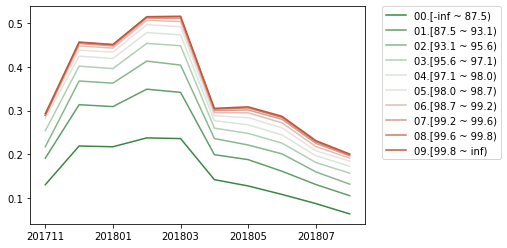

In [112]:
colormap = sns.diverging_palette(130, 20, as_cmap=True)

df_bad_rate.set_index('score_bin').T.plot(kind='line', stacked=True, colormap=colormap)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [106]:
df_bad_rate.set_index('score_bin')

,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
score_bin,,,,,,,,,,
00.[-inf ~ 87.5),0.130597,0.218995,0.217289,0.237505,0.235980,0.142163,0.127736,0.108372,0.087516,0.063907
01.[87.5 ~ 93.1),0.060606,0.094300,0.091696,0.111265,0.105478,0.057023,0.060103,0.052911,0.043499,0.041653
02.[93.1 ~ 95.6),0.026022,0.054105,0.053518,0.064087,0.062323,0.036869,0.033434,0.039732,0.028907,0.026308
03.[95.6 ~ 97.1),0.036496,0.033854,0.033206,0.040416,0.044221,0.023714,0.026519,0.024515,0.021462,0.025043
04.[97.1 ~ 98.0),0.028037,0.022913,0.023152,0.024647,0.024804,0.016980,0.019589,0.018733,0.015472,0.015891
05.[98.0 ~ 98.7),0.007435,0.013738,0.014466,0.018153,0.018679,0.011190,0.016132,0.016298,0.011273,0.011718
06.[98.7 ~ 99.2),0.000000,0.009580,0.009294,0.009917,0.011696,0.007178,0.011261,0.011304,0.009629,0.006878
07.[99.2 ~ 99.6),0.000000,0.005385,0.004675,0.005008,0.007041,0.004688,0.006538,0.008054,0.007299,0.005172
08.[99.6 ~ 99.8),0.000000,0.002620,0.002669,0.002369,0.003774,0.003371,0.004796,0.004443,0.003848,0.002361


In [90]:
df_bad_rate

,score_bin,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808
0,00.[-inf ~ 87.5),0.104118,0.140679,0.112179,0.135431,0.102848,0.071312,0.078867,0.035898,0.034847,0.050992
1,01.[87.5 ~ 93.1),0.115385,0.129593,0.103407,0.116453,0.104691,0.093955,0.095961,0.063146,0.061138,0.077643
2,02.[93.1 ~ 95.6),0.104507,0.116623,0.097638,0.104252,0.102052,0.098967,0.101007,0.077563,0.074999,0.086333
3,03.[95.6 ~ 97.1),0.106449,0.113094,0.097540,0.100057,0.102350,0.103227,0.105883,0.089615,0.092935,0.099565
4,04.[97.1 ~ 98.0),0.083139,0.095219,0.088758,0.087979,0.091905,0.094521,0.096853,0.093658,0.096216,0.099430
5,05.[98.0 ~ 98.7),0.104507,0.097052,0.095715,0.091476,0.097682,0.102153,0.103493,0.112332,0.123085,0.116933
6,06.[98.7 ~ 99.2),0.093240,0.090050,0.094228,0.088150,0.092791,0.096519,0.101083,0.121470,0.132089,0.122031
7,07.[99.2 ~ 99.6),0.105284,0.090029,0.106753,0.096546,0.101635,0.105918,0.113169,0.149648,0.154463,0.136042
8,08.[99.6 ~ 99.8),0.080808,0.057146,0.077001,0.068033,0.072834,0.078771,0.083079,0.109891,0.108921,0.094110
9,09.[99.8 ~ inf),0.102564,0.070514,0.126779,0.111622,0.131213,0.154656,0.120606,0.146780,0.121307,0.116921
